# Ensemble of 4 cosine distance classifier as Simple Averaging

This notebook shows that thealgorithm for quantum Ensemble is able to reproduce the average of multiple cosine classifiers with just one implementation of the quantum cosine classifier

Import pakages and functions

In [1]:
%matplotlib inline

import sys
sys.path.insert(1, '../')

from Utils import *
from modeling import *

c:\users\anton\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Create custom dataset and compute the prediction of the cosine classifier of each training vector classicaly

In [2]:
# Load data without normalisation
X_data, Y_data, x_test = load_data_custom(normalize = False)

# Define the cosine classifier
def cosine_classifier(x,y):
    return 1/2 + (cosine_similarity([x], [y])**2)/2

# Create table as shown in the paper (Table 1)
data = pd.DataFrame(X_data, columns = [r'$X_1$', r'$X_2$']) #cosine_classifier(X_data[0], x_test)[0]
y = [c[1] for c in Y_data]
p = [cosine_classifier(x, x_test)[0][0] for x in X_data]
dist = [cosine_similarity([x], [x_test])[0][0] for x in X_data]
probs = []
dist = np.round(dist,2)

for i,j in zip(y,p):
    if i == 0:
        probs.append(1-j)
    else:
        probs.append(j)

probs = np.array(probs)
data[r'$y$'] = np.array(y)
data[r'$d(\cdot, \tilde{x})$'] = dist
data[r'$P(\tilde{y}=1|x_b, y_b)$'] = probs
data.index = [r'$x_1$', r'$x_2$', r'$x_3$', r'$x_4$',]

In [3]:
data

,$X_1$,$X_2$,$y$,"$d(\cdot, \tilde{x})$","$P(\tilde{y}=1|x_b, y_b)$"
$x_1$,1,3,0,0.89,0.10
$x_2$,-2,2,1,0.00,0.50
$x_3$,3,0,0,0.71,0.25
$x_4$,3,1,1,0.89,0.90


#### Quantum cosine classifiers

In [4]:
# Load normalised data
X_data, Y_data, x_test = load_data_custom()

Implement and execute the four quantum cosine classifiers: for each training point in X_data we build the cosine classifier to compute the target variable for the test point $\tilde{x}$. Thus, given the measurements we retrieve the probabilities with the function retrieve_proba.

In [5]:
qc1 = cos_classifier(X_data[0], x_test, Y_data[0] )
r1 = exec_simulator(qc1)
r1 = retrieve_proba(r1) 

qc2 = cos_classifier(X_data[1], x_test, Y_data[1])
r2 = exec_simulator(qc2)
r2 = retrieve_proba(r2)

qc3 = cos_classifier(X_data[2], x_test, Y_data[2])
r3 = exec_simulator(qc3)
r3 = retrieve_proba(r3)

qc4 = cos_classifier(X_data[3], x_test, Y_data[3])
r4 = exec_simulator(qc4)
r4 = retrieve_proba(r4)

out = [r1, r2, r3, r4]

In [6]:
# qc1.draw(output='text')

We compute the average of the predictions provided by the four quantum cosine classifiers that correspond to the theoretical ensemble prediction, using simple averaging as aggregation strategy.

In [7]:
p0 = [p[0] for p in out]
p1 = [p[1] for p in out]
r_avg = [np.mean(p0), np.mean(p1)]
# print(np.mean(p0), np.mean(p1))

We build the ensemble of the four quantum cosine classifiers. In particular we set $d=2$ so that the ensemble size is equal to $B=2^d$. The data register is composed by $8$ qubits($4$ contains the normalised value of the trainin vectors encoded in the amplitud, other four are for the labels, in particular quantum state $ \left| 0 \right\rangle $ for class $0$ and state $ \left| 1 \right\rangle$ for class $1$.

Since we build an ensemble of $4$ classifiers we need $2 \times d$ of  $U_{(i,j)}$ gates, each of them corresponds to a two swap operations:

$$U_{(1,1)} = \text{swap}(x_0,x_2) \times \text{swap}(y_0,y_2)$$
$$U_{(1,2)} = \text{swap}(x_1,x_3) \times \text{swap}(y_1,y_3)$$
$$U_{(2,1)} = \mathbb{I} \times \mathbb{I} $$
$$U_{(2,2)} = \text{swap}(x_2,x_3) \times \text{swap}(y_2,y_3)$$

where $ \mathbb{I}$ is the identity matrix. This choice for the $U_{(i,j)}$ guarantees that each qubit of the control register is entangled with a different point of data.


In [8]:
qc = ensemble_fixed_U(X_data, Y_data, x_test)

In [9]:
r = exec_simulator(qc, n_shots=8192)
r_ens = retrieve_proba(r)
print(r_ens)

[0.566650390625, 0.433349609375]


In [10]:
qc.draw(output='text')

┌───┐               ░       ┌───┐       ░            »
       d_0: ─────────────┤ H ├───────────────░──■──■─┤ X ├─■──■──░────────────»
                         ├───┤               ░  │  │ └───┘ │  │  ░ ┌───┐      »
       d_1: ─────────────┤ H ├───────────────░──┼──┼───────┼──┼──░─┤ X ├─■──■─»
            ┌────────────┴───┴────────────┐  ░  │  │       │  │  ░ └───┘ │  │ »
       x_0: ┤ initialize(0.31623,0.94868) ├──░──X──┼───────┼──┼──░───────┼──┼─»
            ├─────────────────────────────┴┐ ░  │  │       │  │  ░       │  │ »
       x_1: ┤ initialize(-0.70711,0.70711) ├─░──┼──┼───────X──┼──░───────┼──┼─»
            └─────┬─────────────────┬──────┘ ░  │  │       │  │  ░       │  │ »
       x_2: ──────┤ initialize(1,0) ├────────░──X──┼───────┼──┼──░───────X──┼─»
            ┌─────┴─────────────────┴─────┐  ░     │       │  │  ░       │  │ »
       x_3: ┤ initialize(0.94868,0.31623) ├──░─────┼───────X──┼──░───────X──┼─»
            └─────┬─────────────────┬─────┘  ░     │          │  ░          │ »
       y_0: ──────┤ initialize(1,0) ├────────░─────X──────────┼──░──────────┼─»
                  ├─────────────────┤        ░     │          │  ░          │ »
       y_1: ──────┤ initialize(0,1) ├────────░─────┼──────────X──░──────────┼─»
                  ├─────────────────┤        ░     │          │  ░          │ »
       y_2: ──────┤ initialize(1,0) ├────────░─────X──────────┼──░──────────X─»
                  ├─────────────────┤        ░                │  ░          │ »
       y_3: ──────┤ initialize(0,1) ├────────░────────────────X──░──────────X─»
            ┌─────┴─────────────────┴─────┐  ░                   ░            »
x^{test}_0: ┤ initialize(0.70711,0.70711) ├──░───────────────────░────────────»
            └─────────────────────────────┘  ░                   ░ ┌───┐      »
y^{test}_0: ─────────────────────────────────░───────────────────░─┤ H ├──────»
                                             ░                   ░ └───┘      »
       c_0: ══════════════════════════════════════════════════════════════════»
                                                                              »
«                            
«       d_0: ────────────────
«                            
«       d_1: ────────────────
«                            
«       x_0: ────────────────
«                            
«       x_1: ────────────────
«                            
«       x_2: ────────────────
«                            
«       x_3: ─X──────────────
«             │              
«       y_0: ─┼──────────────
«             │              
«       y_1: ─┼──────────────
«             │              
«       y_2: ─┼──────────────
«             │              
«       y_3: ─┼────────■─────
«             │        │     
«x^{test}_0: ─X────────┼─────
«             │ ┌───┐┌─┴─┐┌─┐
«y^{test}_0: ─■─┤ H ├┤ X ├┤M├
«               └───┘└───┘└╥┘
«       c_0: ══════════════╩═
«

In [11]:
# collect the results
out_sim = [r1, r2, r3, r4, r_avg, r_ens]

In [12]:
def plot_cls(predictions,
             #labels=['$f_1$', '$f_2$', '$f_3$', '$f_4$', 'AVG', '$Ensemble$'],
             title='Test point classification',
             file='ens_vs_single.png'):
    N = len(predictions)
    fig, ax = plt.subplots(figsize=(50,100))
    plt.rc('text', usetex=True)
    #plt.rc('font', family='serif')
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35  # the width of the bars
    prob_0 = [p[0] for p in predictions]
    prob_1 = [p[1] for p in predictions]
    # label = [l['label'] for l in dictionary]
    pl1 = ax.bar(ind, prob_0, width, bottom=0)
    pl2 = ax.bar(ind + width, prob_1, width, bottom=0)
    ax.set_title(title)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels([r'$f_1$', r'$f_2$', r'$f_3$', r'$f_4$', 'AVG', 'Ensemble'], size=14)
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],size=14)
    ax.legend((pl1[0], pl2[0]), (r'$P(\tilde{y}=0)$', r'$P(\tilde{y}=1)$'), prop=dict(size=14))
    ax.autoscale_view()
    plt.ylim(0, 1)
    plt.xlabel('Classifier', fontsize=18)
    #plt.xlabel(r'$P(\tilde{y})')
    plt.grid(alpha=.2)
    #ax.tick_params(pad=5)
    if file is not None:
        plt.savefig('output/' + file + '.png', dpi=200,  bbox_inches='tight')
    plt.show()


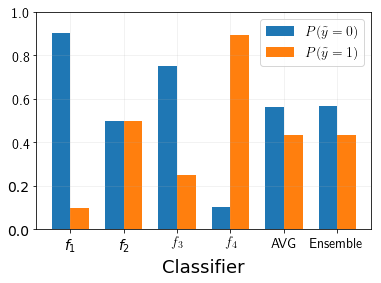

In [13]:
plot_cls(out_sim, title= '', file='SIM_ens_vs_single')

In [26]:
data_pred = pd.DataFrame(out, columns=['p0', 'p1'])
data_pred.to_csv('output/sim_results.csv', index=False)

### Conclusion: the probability provided by the quantum cosine classifier are pretty much the same to the classical cosine classifier. Furthermore the average of the four classifier is almost the same to the ensemble prediction where it is required only one execution of the cosine classifier

##### Perform the same computation in real device

In [14]:
# Execution on real device
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend_16 = provider.get_backend('ibmq_16_melbourne')
backend_5 = provider.get_backend('ibmq_london')

# optimization_level=3

def run_real_device(qc, backend, shots=8192):
    job = execute(qc, backend, shots=shots)
    results = job.result()
    r = results.get_counts(qc)
    return r

In [15]:
qc1 = cos_classifier(X_data[0], x_test, Y_data[0])
r1 = run_real_device(qc1, backend_5)
r1 = retrieve_proba(r1)

qc2 = cos_classifier(X_data[1], x_test, Y_data[1])
r2 = run_real_device(qc2, backend_5)
r2 = retrieve_proba(r2)

qc3 = cos_classifier(X_data[2], x_test, Y_data[2])
r3 = run_real_device(qc3, backend_5)
r3 = retrieve_proba(r3)

qc4 = cos_classifier(X_data[3], x_test, Y_data[3])
r4 = run_real_device(qc4, backend_5)
r4 = retrieve_proba(r4)

out = [r1, r2, r3, r4]

p0 = [p[0] for p in out]
p1 = [p[1] for p in out]
r_avg = [np.mean(p0), np.mean(p1)]

In [16]:
print(out)

[[0.7833251953125, 0.2166748046875], [0.525634765625, 0.474365234375], [0.693359375, 0.306640625], [0.41259765625, 0.58740234375]]


In [17]:
#backend = provider.get_backend('ibmq_16_melbourne')

qc = ensemble_fixed_U(X_data, Y_data, x_test)
qc = transpile(qc, basis_gates = ['u1', 'u2', 'u3', 'cx'], optimization_level=3)

r_ens = run_real_device(qc, backend_16)
r_ens = retrieve_proba(r_ens)
print(r_ens)

[0.4962158203125, 0.5037841796875]


In [18]:
out_real = [r1, r2, r3, r4, r_avg, r_ens]

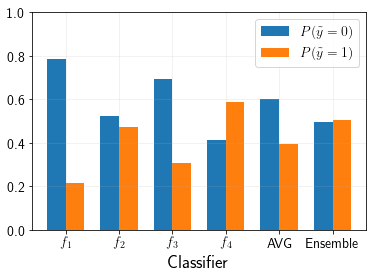

In [19]:
plot_cls(out_real, title='', file='RL_ens_vs_single')

In [20]:
data_pred = pd.DataFrame(out, columns=['p0', 'p1'])
data_pred.to_csv('output/rl_results.csv', index=False)

In [176]:

def plot_cls(predictions,
             #labels=['$f_1$', '$f_2$', '$f_3$', '$f_4$', 'AVG', '$Ensemble$'],
             title='Test point classification',
             file='ens_vs_single.png'):
    fontsize=28
    N = len(predictions)
    fig, ax = plt.subplots(figsize=(12,3))
    plt.rc('text', usetex=True)
    #plt.rc('font', family='serif')
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35  # the width of the bars
    prob_0 = [p[0] for p in predictions]
    prob_1 = [p[1] for p in predictions]
    # label = [l['label'] for l in dictionary]
    pl1 = ax.bar(ind, prob_0, width, bottom=0, color='orange')
    pl2 = ax.bar(ind + width, prob_1, width, bottom=0, color='blue')
    ax.set_title(title, size=fontsize)#, y=0, pad=-65)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels([r'$f_1$', r'$f_2$', r'$f_3$', r'$f_4$', 'AVG', 'Ensemble'], size=fontsize)
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],size=fontsize)
    # ax.legend((pl1[0], pl2[0]), (r'$P(\tilde{y}=0)$', r'$P(\tilde{y}=1)$'), prop=dict(size=20))
    ax.autoscale_view()
    plt.ylim(0, 1)
    #plt.xlabel('Classifier', fontsize=18)
    #plt.xlabel(r'$P(\tilde{y})')
    plt.grid(alpha=.2)
    ax.tick_params(pad=10)
    if file is not None:
        plt.savefig('output/' + file + '.png', dpi=200,  bbox_inches='tight')
    plt.show()

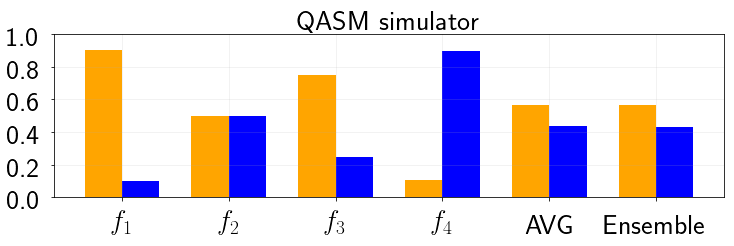

In [177]:
plot_cls(out_sim, title= 'QASM simulator', file='SIM_ens_vs_single')

In [174]:
def plot_cls(predictions,
             #labels=['$f_1$', '$f_2$', '$f_3$', '$f_4$', 'AVG', '$Ensemble$'],
             title='Test point classification',
             file='ens_vs_single.png'):
    fontsize=28
    N = len(predictions)
    fig, ax = plt.subplots(figsize=(12,3))
    plt.rc('text', usetex=True)
    #plt.rc('font', family='serif')
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35  # the width of the bars
    prob_0 = [p[0] for p in predictions]
    prob_1 = [p[1] for p in predictions]
    # label = [l['label'] for l in dictionary]
    pl1 = ax.bar(ind, prob_0, width, bottom=0, color='orange')
    pl2 = ax.bar(ind + width, prob_1, width, bottom=0, color='blue')
    ax.set_title(title, size=fontsize)#, y=0, pad=-65)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels([r'$f_1$', r'$f_2$', r'$f_3$', r'$f_4$', 'AVG', 'Ensemble'], size=fontsize)
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],size=fontsize)
    ax.legend((pl1[0], pl2[0]), (r'$P(\tilde{y}=0)$', r'$P(\tilde{y}=1)$'), 
              prop=dict(size=fontsize), bbox_to_anchor = (.82, -0.2), ncol=2)
    ax.autoscale_view()
    plt.ylim(0, 1)
    #plt.xlabel('Classifier', fontsize=fontsize)
    #plt.xlabel(r'$P(\tilde{y})')
    plt.grid(alpha=.2)
    ax.tick_params(pad=10)
    if file is not None:
        plt.savefig('output/' + file + '.png', dpi=200,  bbox_inches='tight')
    plt.show()

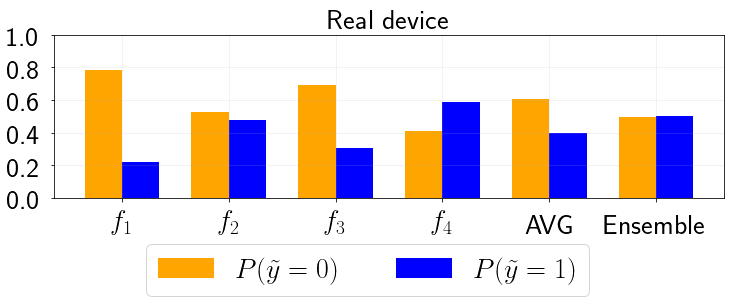

In [175]:
plot_cls(out_real, title='Real device', file='RL_ens_vs_single')

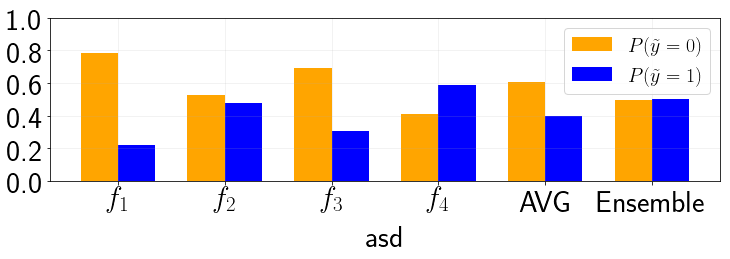

In [104]:
# ax = sns.boxplot(x="dev", y="brier", hue="d", data=data)
predictions = out_real
fontsize=30
width = 0.35
fig, ax = plt.subplots(figsize=(12,3))
ind = np.arange(6)  # the x locations for the groups
prob_0 = [p[0] for p in predictions]
prob_1 = [p[1] for p in predictions]
pl1 = ax.bar(ind, prob_0, width, bottom=0, color='orange')
pl2 = ax.bar(ind + width, prob_1, width, bottom=0, color='blue')
ax.set_title('asd', size=fontsize, y=0, pad=-65)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels([r'$f_1$', r'$f_2$', r'$f_3$', r'$f_4$', 'AVG', 'Ensemble'], size=fontsize)
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],size=fontsize)
legend = ax.legend((pl1[0], pl2[0]), (r'$P(\tilde{y}=0)$', r'$P(\tilde{y}=1)$'), prop=dict(size=20))
ax.autoscale_view()
plt.ylim(0, 1)
plt.grid(alpha=.2)


In [103]:
labels

[]

TypeError: zip argument #2 must support iteration

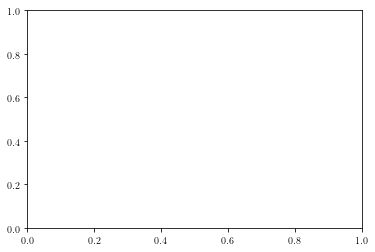

In [105]:
handles, labels = ax.get_legend_handles_labels()
fig, ax = plt.subplots()
fig.legend(legend, loc='center', ncol=2)
plt.savefig('output/legend_prediction.png', dpi=150, bbox_inches='tight')